In [5]:
# ============================================================================
# This code was generated by Claude Sonnet 4.5 and modified by the instructor.
# ============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import copy

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ============================================================================
# 1. DATA PREPARATION WITH IMBALANCED CLIENT DISTRIBUTION
# ============================================================================

def create_imbalanced_client_data(n_clients=5, samples_per_client=800):
    """Create imbalanced federated datasets with all 10 classes per client"""
    
    # Load CIFAR-10
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    full_train = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                              download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                                download=True, transform=transform)
    
    # Organize by class
    class_indices = defaultdict(list)
    for idx, (_, label) in enumerate(full_train):
        class_indices[label].append(idx)
    
    # Create imbalanced distribution for each client
    client_datasets = []
    holdout_indices = []
    
    for client_id in range(n_clients):
        client_indices = []
        
        # Generate different imbalance ratios for each client
        # Each client gets all 10 classes but with different proportions
        np.random.seed(42 + client_id)
        class_weights = np.random.dirichlet(np.ones(10) * 0.5)  # Imbalanced
        
        for class_id in range(10):
            n_samples = int(samples_per_client * class_weights[class_id])
            n_samples = max(n_samples, 10)  # At least 10 samples per class
            
            available = class_indices[class_id]
            selected = np.random.choice(available, size=n_samples, replace=False)
            client_indices.extend(selected)
            
            # Remove selected indices
            class_indices[class_id] = [x for x in available if x not in selected]
        
        client_datasets.append(Subset(full_train, client_indices))
    
    # Create holdout set from remaining data
    remaining_indices = []
    for class_id in range(10):
        remaining_indices.extend(class_indices[class_id][:100])
    holdout_dataset = Subset(full_train, remaining_indices)
    
    return client_datasets, test_dataset, holdout_dataset


def visualize_client_data(client_datasets, n_samples=5):
    """Visualize samples from each client dataset"""
    n_clients = len(client_datasets)
    
    fig, axes = plt.subplots(n_clients, n_samples, figsize=(12, 2*n_clients))
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']
    
    for client_id, dataset in enumerate(client_datasets):
        indices = np.random.choice(len(dataset), n_samples, replace=False)
        
        for i, idx in enumerate(indices):
            img, label = dataset[idx]
            img = img / 2 + 0.5  # Denormalize
            img = img.permute(1, 2, 0).numpy()
            
            ax = axes[client_id, i] if n_clients > 1 else axes[i]
            ax.imshow(img)
            ax.axis('off')
            if i == 0:
                ax.set_title(f'Client {client_id}', fontsize=10)
            ax.text(0.5, -0.1, classes[label], transform=ax.transAxes,
                   ha='center', fontsize=8)
    
    plt.tight_layout()

    plt.savefig('./outputs/client_data_samples.png', dpi=150, bbox_inches='tight')
    plt.show()  # Add this line to display in Jupyter
    plt.close()
    print("✓ Visualization saved")


def print_client_statistics(client_datasets):
    """Print distribution statistics for each client"""
    print("\n" + "="*60)
    print("CLIENT DATA DISTRIBUTION")
    print("="*60)
    
    for client_id, dataset in enumerate(client_datasets):
        class_counts = defaultdict(int)
        for _, label in dataset:
            class_counts[label] += 1
        
        print(f"\nClient {client_id} (Total: {len(dataset)} samples):")
        print("  " + " ".join([f"C{i}:{class_counts[i]:3d}" for i in range(10)]))


# ============================================================================
# 2. MODEL DEFINITION
# ============================================================================

class CNN(nn.Module):
    """3-layer CNN for CIFAR-10"""
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# ============================================================================
# 3. EVALUATION FUNCTION
# ============================================================================

def evaluate(model, test_loader):
    """Evaluate model accuracy on test set"""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return 100 * correct / total




def evaluate_per_class(model, test_loader):
    """Evaluate per-class accuracy"""
    model.eval()
    class_correct = defaultdict(int)
    class_total = defaultdict(int)
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            for label, pred in zip(labels, predicted):
                label_item = label.item()
                class_total[label_item] += 1
                if label_item == pred.item():
                    class_correct[label_item] += 1
    
    class_acc = {i: 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 
                 for i in range(10)}
    
    return class_acc


# ============================================================================
# 4. CENTRALIZED TRAINING
# ============================================================================

def train_centralized(client_datasets, test_loader, epochs=10, lr=0.001):
    """Train single model on all client data combined"""
    print("\n" + "="*60)
    print("CENTRALIZED TRAINING")
    print("="*60)
    
    # Combine all client data
    all_indices = []
    base_dataset = client_datasets[0].dataset
    for client_dataset in client_datasets:
        all_indices.extend(client_dataset.indices)
    
    combined_dataset = Subset(base_dataset, all_indices)
    train_loader = DataLoader(combined_dataset, batch_size=64, shuffle=True)
    
    model = CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        if (epoch + 1) % 2 == 0:
            acc = evaluate(model, test_loader)
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Acc: {acc:.2f}%")
    
    final_acc = evaluate(model, test_loader)
    print(f"\nFinal Centralized Accuracy: {final_acc:.2f}%")
    
    return model, final_acc



## Train centralized model, and report the model performance (as an upper bound)


[1/5] Creating imbalanced client datasets...
Files already downloaded and verified
Files already downloaded and verified

CLIENT DATA DISTRIBUTION

Client 0 (Total: 818 samples):
  C0: 42 C1:201 C2: 10 C3: 10 C4:115 C5: 10 C6:335 C7: 10 C8: 28 C9: 57

Client 1 (Total: 828 samples):
  C0: 10 C1: 10 C2: 24 C3:112 C4: 10 C5: 35 C6:306 C7: 37 C8: 10 C9:274

Client 2 (Total: 801 samples):
  C0: 99 C1: 62 C2: 11 C3: 13 C4: 23 C5:280 C6: 10 C7:225 C8: 40 C9: 38

Client 3 (Total: 821 samples):
  C0: 10 C1: 24 C2: 10 C3: 10 C4:159 C5: 50 C6:514 C7: 24 C8: 10 C9: 10

Client 4 (Total: 825 samples):
  C0:147 C1: 10 C2: 17 C3: 10 C4:328 C5: 31 C6:235 C7: 10 C8: 27 C9: 10


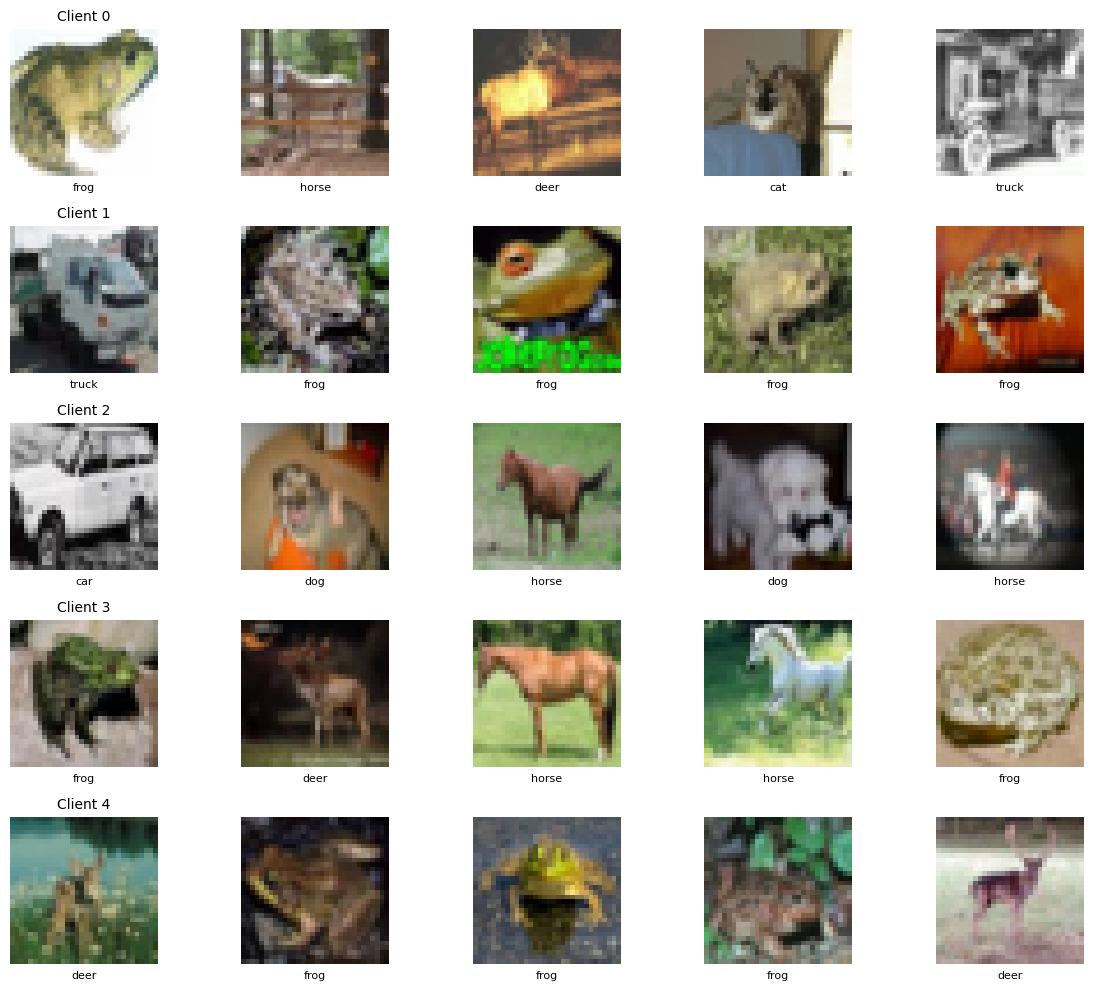

✓ Visualization saved

Test set size: 10000
Holdout set size: 1000

[2/5] Running centralized training...

CENTRALIZED TRAINING
Epoch [2/100], Loss: 1.7077, Acc: 25.72%
Epoch [4/100], Loss: 1.4498, Acc: 33.90%
Epoch [6/100], Loss: 1.2926, Acc: 37.82%
Epoch [8/100], Loss: 1.1706, Acc: 43.59%
Epoch [10/100], Loss: 1.0697, Acc: 44.15%
Epoch [12/100], Loss: 0.9561, Acc: 46.42%
Epoch [14/100], Loss: 0.9010, Acc: 47.84%
Epoch [16/100], Loss: 0.8103, Acc: 48.68%
Epoch [18/100], Loss: 0.7242, Acc: 45.44%
Epoch [20/100], Loss: 0.6493, Acc: 49.87%
Epoch [22/100], Loss: 0.5702, Acc: 51.06%
Epoch [24/100], Loss: 0.4901, Acc: 49.21%
Epoch [26/100], Loss: 0.4579, Acc: 49.31%
Epoch [28/100], Loss: 0.4030, Acc: 48.84%
Epoch [30/100], Loss: 0.3314, Acc: 51.28%
Epoch [32/100], Loss: 0.3109, Acc: 51.01%
Epoch [34/100], Loss: 0.2549, Acc: 50.89%
Epoch [36/100], Loss: 0.2266, Acc: 51.20%
Epoch [38/100], Loss: 0.2063, Acc: 50.36%
Epoch [40/100], Loss: 0.2021, Acc: 50.67%
Epoch [42/100], Loss: 0.1752, Acc: 5

In [3]:

# 1. Create client datasets
print("\n[1/5] Creating imbalanced client datasets...")
client_datasets, test_dataset, holdout_dataset = create_imbalanced_client_data(
    n_clients=5, samples_per_client=800
)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print_client_statistics(client_datasets)
visualize_client_data(client_datasets)

print(f"\nTest set size: {len(test_dataset)}")
print(f"Holdout set size: {len(holdout_dataset)}")

# Centralized training
print("\n[2/5] Running centralized training...")
central_model, central_acc = train_centralized(client_datasets, test_loader, epochs=100)
print(f"Centralized Accuracy:        {central_acc:.2f}%")

In [6]:
central_class_acc = evaluate_per_class(central_model, test_loader)
print("\nPer-Class Accuracy:")
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i, cls in enumerate(classes):
    print(f"  {cls:8s}: {central_class_acc[i]:5.2f}%")


Per-Class Accuracy:
  plane   : 69.30%
  car     : 62.30%
  bird    :  4.10%
  cat     : 11.30%
  deer    : 59.30%
  dog     : 50.60%
  frog    : 92.10%
  horse   : 54.10%
  ship    : 30.60%
  truck   : 69.90%


## TODO Sections below

In [8]:



# ============================================================================
# TODO: LOCALIZED TRAINING
# ============================================================================

def train_localized(client_datasets, test_loader, epochs=10, lr=0.001):
    """Train separate model for each client"""
    ######### TODO complete this part ###########
    #############################################
    return


 

# ============================================================================
# TODO: FEDERATED TRAINING
# ============================================================================


def train_federated(client_datasets, test_loader, rounds=20, local_epochs=5, lr=0.001):
    """Federated learning with FedAvg"""
    print("\n" + "="*60)
    print("FEDERATED LEARNING (FedAvg)")
    print("="*60)
    
    # Initialize global model
    global_model = CNN().to(device)
    
    for round_num in range(rounds):
        local_models = []
        
        # Local training on each client
        for client_id, client_dataset in enumerate(client_datasets):
            
            ######### TODO complete this part ###########
            #############################################
            pass
        
        # Aggregate models
         
        
        # Evaluate
        if (round_num + 1) % 5 == 0:
            acc = evaluate(global_model, test_loader)
            print(f"Round [{round_num+1}/{rounds}], Global Accuracy: {acc:.2f}%")
    
    final_acc = evaluate(global_model, test_loader)
    print(f"\nFinal Federated Accuracy: {final_acc:.2f}%")
    
    return global_model, final_acc

